In [53]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import scipy.stats as stats
import statsmodels.api as sm  

In [54]:
data = pd.read_csv('starts.csv')
regions = pd.read_csv('regions.csv')

In [55]:
data = data[data['finish_time'] < 3600]
data = data[data['athlete_age'] < 80]

In [56]:
#merging tables and removing duplicates
data = data.merge(regions, on='region', how='left')
unique_runners = data.drop_duplicates(subset=['region', 'athlete_id'])

In [57]:
unique_runners.shape

(37432, 93)

In [58]:

unique_runners.athlete_id.nunique()

31556

~ 6 тысяч бегали в более чем одном регионе

In [59]:
#share of newbies by regions
newbie_ratios = (
    unique_runners
    .groupby('region', as_index=False)
    .agg(newbie_ratio=('is_newbie', lambda x: x.sum() / len(x)), total_pro_runners=('is_newbie', lambda x: len(x[unique_runners.is_newbie == 0])))
)

In [60]:

print(len(data[(data.region == 'Архангельская область') & (data.is_newbie == 1)].drop_duplicates('athlete_id')))
print(len(data[(data.region == 'Архангельская область')].drop_duplicates('athlete_id')))
display(newbie_ratios)

50
64


,region,newbie_ratio,total_pro_runners
0,Архангельская область,0.781250,14
1,Астраханская область,0.723926,45
2,Белгородская область,0.584507,177
3,Владимирская область,0.560563,156
4,Волгоградская область,0.664502,155
5,Воронежская область,0.724057,117
6,Иркутская область,0.743003,101
7,Калининградская область,0.599476,153
8,Калужская область,0.518868,153
9,Кемеровская область,0.648889,79


Проверим распределение на нормальность

<Axes: xlabel='newbie_ratio', ylabel='Count'>

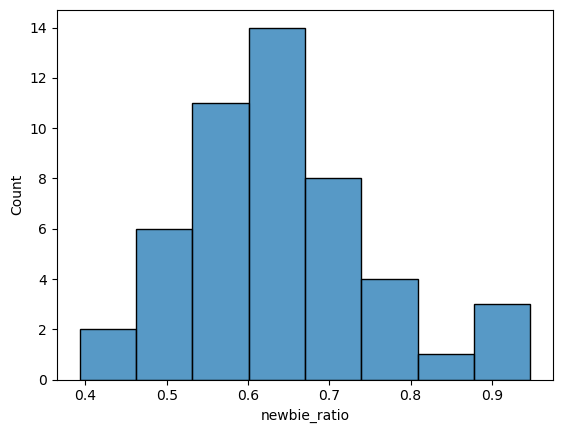

In [61]:
sns.histplot(newbie_ratios.newbie_ratio)

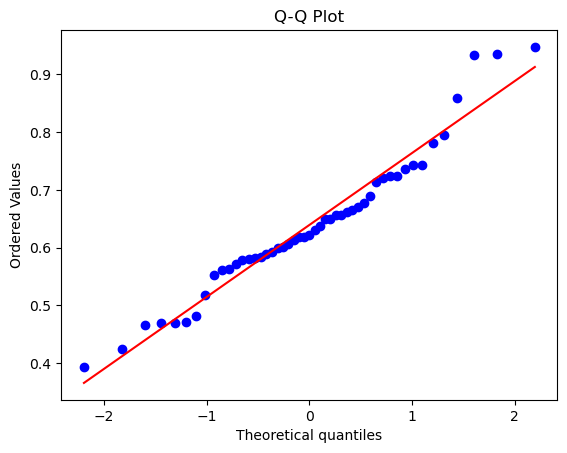

In [62]:
stats.probplot(newbie_ratios.newbie_ratio, dist="norm", plot=plt)
plt.title("Q-Q Plot")
plt.show()

Все отлично за исключением хвоста в конце

In [63]:
stats.shapiro(newbie_ratios.newbie_ratio)

ShapiroResult(statistic=0.9575956463813782, pvalue=0.07543288171291351)

Можем считать распределение нормальным

далее Максим

In [64]:
# ДАЛЕЕ МАКСИМ делает

newbie_ratios.head(2)

,region,newbie_ratio,total_pro_runners
0,Архангельская область,0.781250,14
1,Астраханская область,0.723926,45


In [65]:
reg = newbie_ratios.merge(regions, how='left', on='region')
print(reg.shape[0])
display(reg.head(2))

49


,region,newbie_ratio,total_pro_runners,per_capita_income_rub,median_income_per_capita_rub,milk_consumption_per_capita,sugar_consumption_per_capita,urban_population_pct,male_to_female_ratio,under_working_age_population_pct,...,disabled_population_per_1000,population_total,crimes_murder_attempts,crimes_grievous_bodily_harm,crimes_robbery,crimes_armed_robbery,crimes_hooliganism,crimes_drug_related,nominal_wages_avg_rub,poverty_rate_pct_region
0,Архангельская область,0.781250,14,48356,35748.2,206.0,40.0,77.7,1162.0,18.1,...,79.0,1016.0,116,178,471,47,10,1109,67835,11.8
1,Астраханская область,0.723926,45,31119,25038.0,200.0,44.0,64.1,1129.0,21.2,...,47.2,957.8,29,93,147,19,13,1135,47780,13.8


Далее я хочу удалить не стат значимые (p_value > 0.05) корреляции с newbie_ratio.

Щас сделаю по корреляции СПИРМЕНА


In [66]:
reg['air_pollutant_relative_per_1000_person'] = reg['air_pollutant_emissions'] / reg['population_total'] * 1000
reg = reg.drop(columns=['air_pollutant_emissions'])
#относительно на 1000 человек считаем

In [67]:
# Фильтруем только целочисленные столбцы  
integer_columns = reg.select_dtypes(include=['number']).columns  

# Переменная для хранения незначимых переменных  
insignificant_vars = []  

# Обходим все целочисленные столбцы  
for col in integer_columns:  
    
    try:
        if col != 'newbie_ratio':  # пропускаем целевую переменную  
        # Рассчитываем коэффициент корреляции Спирмена и p-значение  
            corr, p_value = stats.spearmanr(reg[col], reg['newbie_ratio'])  
        
        # Если p-значение больше 0.05, то переменная не стат значимо влияет на newbie_ratio  
            if p_value > 0.05:  
                insignificant_vars.append(col)  
    except Exception:
        print(f'Nan по {col} столбцу есть')
print()
# Выводим все целочисленные переменные, которые не влияют стат значимо на newbie_ratio  
print("Неподходящие целочисленные переменные:", insignificant_vars)
print(len(insignificant_vars))


Неподходящие целочисленные переменные: ['total_pro_runners', 'per_capita_income_rub', 'median_income_per_capita_rub', 'milk_consumption_per_capita', 'sugar_consumption_per_capita', 'urban_population_pct', 'under_working_age_population_pct', 'working_age_population_pct', 'dependency_ratio', 'death_rate_per_1000', 'infant_mortality_per_1000_births', 'natural_increase_rate_per_1000', 'marriage_rate_per_1000', 'migration_increase_rate_per_10000', 'library_books_per_1000', 'library_users_total', 'forest_coverage_pct', 'disease_incidence_infectious', 'disease_incidence_cancer', 'disease_incidence_blood', 'disease_incidence_endocrine', 'disease_incidence_nervous', 'disease_incidence_eye', 'disease_incidence_ear', 'disease_incidence_circulatory', 'disease_incidence_respiratory', 'disease_incidence_digestive', 'disease_incidence_skin', 'disease_incidence_musculoskeletal', 'disease_incidence_genitourinary', 'disease_incidence_congenital', 'disease_incidence_trauma', 'disease_incidence_all', 'ca

In [68]:
# Удаляем незначимые переменные (по корреляции) из датафрейма  
reg = reg.drop(columns=insignificant_vars)  


Итого у нас удалилось 62 столбца с не стат значимой корреляцией с Newbie_ratio


In [69]:
reg.head(3)
print(reg.columns)


Index(['region', 'newbie_ratio', 'male_to_female_ratio',
       'above_working_age_population_pct', 'birth_rate_per_1000',
       'divorce_rate_per_1000', 'milk_production_total',
       'milk_production_per_cow', 'substance_abuse_patients_per_100k',
       'air_pollutant_relative_per_1000_person'],
      dtype='object')


Посмотрим на корреляции стат значимых переменных влиящие на newbie_ratio

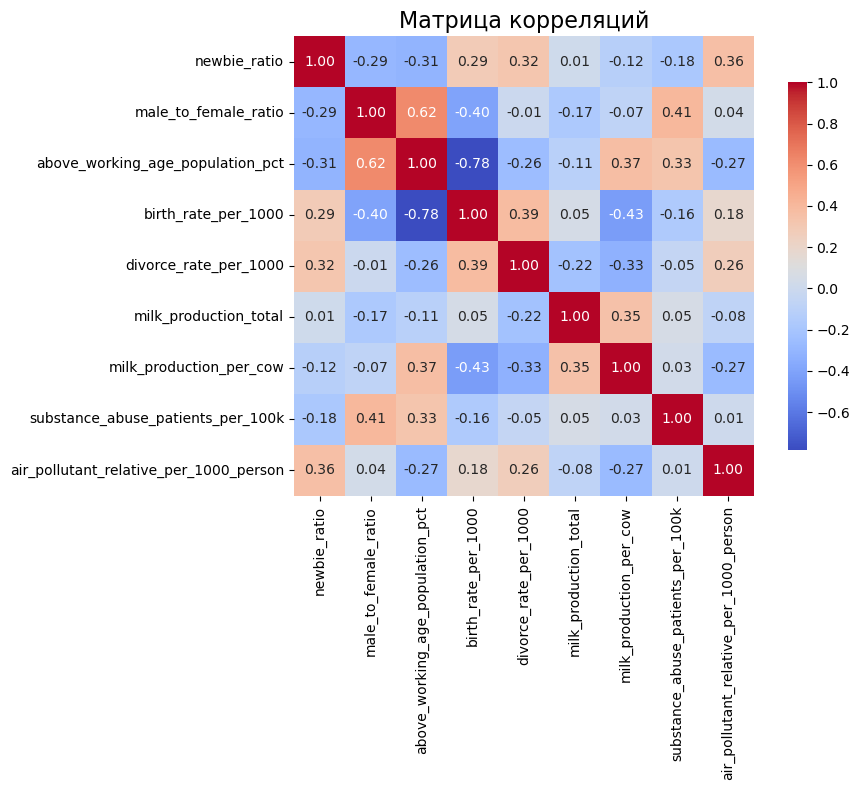

In [70]:
reg_numeric = reg.drop(columns=['region'])  

# Расчет матрицы корреляций  
correlation_matrix = reg_numeric.corr(method='spearman')  

# Настройки визуализации  
plt.figure(figsize=(10, 8))  # Установка размера графика  
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})  

# Добавление заголовка  
plt.title('Матрица корреляций', fontsize=16)  
plt.tight_layout()  # Уплотняем график  
plt.show()  

In [71]:
reg.isnull().sum()


region                                    0
newbie_ratio                              0
male_to_female_ratio                      0
above_working_age_population_pct          0
birth_rate_per_1000                       0
divorce_rate_per_1000                     0
milk_production_total                     1
milk_production_per_cow                   1
substance_abuse_patients_per_100k         1
air_pollutant_relative_per_1000_person    0
dtype: int64

In [72]:
reg[reg['milk_production_total'].isnull()]  # по питеру нет о кол ве произведенного молока

,region,newbie_ratio,male_to_female_ratio,above_working_age_population_pct,birth_rate_per_1000,divorce_rate_per_1000,milk_production_total,milk_production_per_cow,substance_abuse_patients_per_100k,air_pollutant_relative_per_1000_person
36,Санкт-Петербург,0.581375,1217.0,25.5,9.0,4.8,NaN,NaN,1.3,12.482391


In [73]:
reg[reg['substance_abuse_patients_per_100k'].isnull()] #Контингенты пациентов с токсикоманией NAN в архангельской области

,region,newbie_ratio,male_to_female_ratio,above_working_age_population_pct,birth_rate_per_1000,divorce_rate_per_1000,milk_production_total,milk_production_per_cow,substance_abuse_patients_per_100k,air_pollutant_relative_per_1000_person
0,Архангельская область,0.78125,1162.0,26.6,8.1,5.1,141.155,7798.0,NaN,202.755906


In [74]:
reg[reg['milk_production_per_cow'].isnull()] # опять в питере NAN по производству молока одной коровой 

,region,newbie_ratio,male_to_female_ratio,above_working_age_population_pct,birth_rate_per_1000,divorce_rate_per_1000,milk_production_total,milk_production_per_cow,substance_abuse_patients_per_100k,air_pollutant_relative_per_1000_person
36,Санкт-Петербург,0.581375,1217.0,25.5,9.0,4.8,NaN,NaN,1.3,12.482391


в питере по молоку nan потому что, цитата из описания БД: "Производство молока (и надой молока на корову), в хозяйствах всех 
категорий. Значение показателя для 
Ленинградской области включает
г. Санкт-Петербург."

In [75]:
data[data.region == 'Ленинградская область'].city.value_counts()

city
Гатчина    599
Кудрово    572
Name: count, dtype: int64